In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\Murilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('file_path\\consolidated_treated.csv', index_col=0)
df.index.name = 'timestamp'
df.index = pd.to_datetime(df.index)

In [3]:
# Define the split dates using pd.to_datetime
train_start = pd.to_datetime('2021-06-01 00:00:00')
train_end = pd.to_datetime('2021-10-31 23:00:00')
val_end = pd.to_datetime('2021-11-30 23:00:00')

# Split the data
train = df[train_start:train_end]
validation = df[train_end:val_end]
test = df[val_end:]

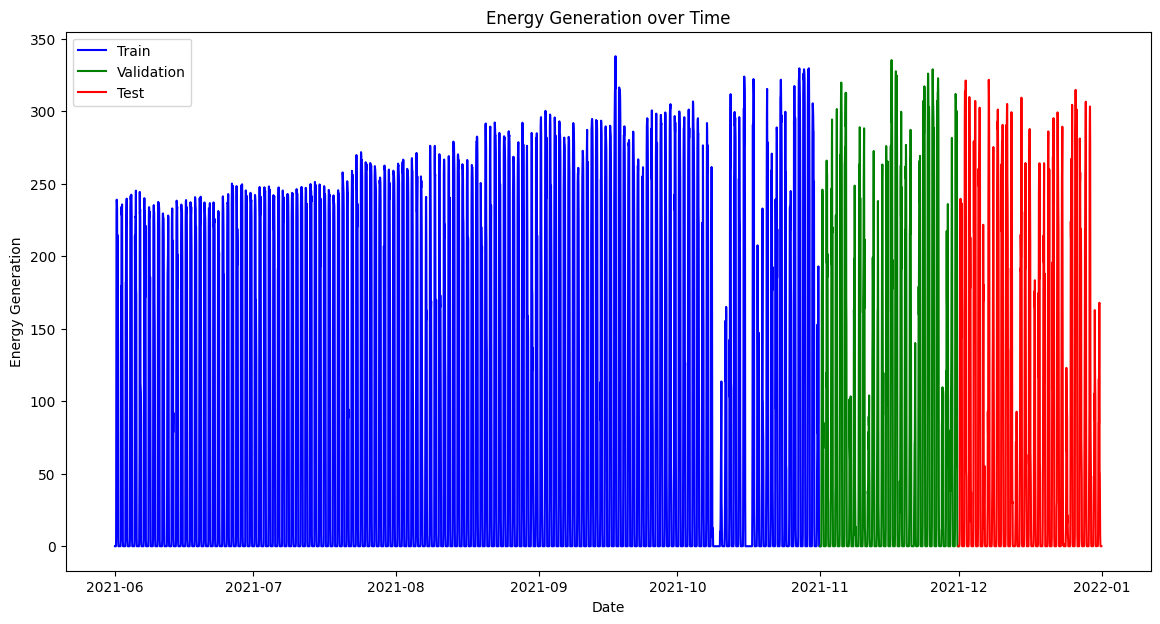

In [4]:
plt.figure(figsize=(14, 7))

plt.plot(train.index, train['val_geracao'], label='Train', color='blue')
plt.plot(validation.index, validation['val_geracao'], label='Validation', color='green')
plt.plot(test.index, test['val_geracao'], label='Test', color='red')

plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.title('Energy Generation over Time')
plt.legend()
plt.show()

MAE: 35.24
MSE: 3875.86


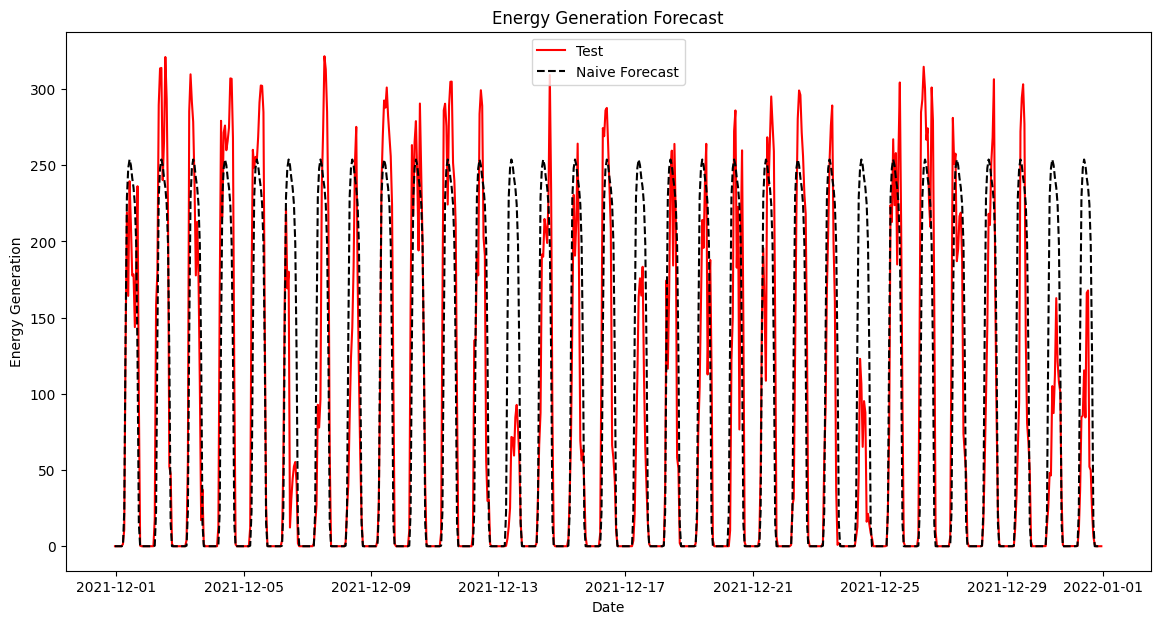

In [8]:
# Naive baseline forecast (historical hourly mean)
hourly_mean = train.groupby(train.index.hour)['val_geracao'].mean()
naive_forecast = test.index.map(lambda x: hourly_mean[x.hour])

# Calculate error metrics
mae = mean_absolute_error(test['val_geracao'], naive_forecast)
mse = mean_squared_error(test['val_geracao'], naive_forecast)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")

# Plot the results
plt.figure(figsize=(14, 7))

plt.plot(test.index, test['val_geracao'], label='Test', color='red')
plt.plot(test.index, naive_forecast, label='Naive Forecast', color='black', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.title('Energy Generation Forecast')
plt.legend()
plt.show()

In [5]:
start_time = time.time()

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

endog_train = train['val_geracao']
exog_train = train.drop(columns=['val_geracao'])

model = SARIMAX(endog_train, order=order, seasonal_order=seasonal_order, trend = 'n', exog=exog_train)
results = model.fit()

steps = 1*720  # Number of hours in a month
endog_validation = validation['val_geracao']
exog_validation = validation.drop(columns=['val_geracao'])
validation_forecast = results.get_forecast(steps=steps, exog=exog_validation.head(steps))
validation_forecast_mean = validation_forecast.predicted_mean

endog_test = test['val_geracao']
exog_test = test.drop(columns=['val_geracao'])
test_forecast = results.get_forecast(steps=steps, exog=exog_test.head(steps))
test_forecast_mean = test_forecast.predicted_mean

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to create, fit, and forecast the model: {elapsed_time:.2f} seconds")


C:\Users\Murilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Murilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Murilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Time taken to create, fit, and forecast the model: 164.88 seconds


Validation MAE: 45.87
Validation MSE: 3516.63
Test MAE: 44.58
Test MSE: 3362.75


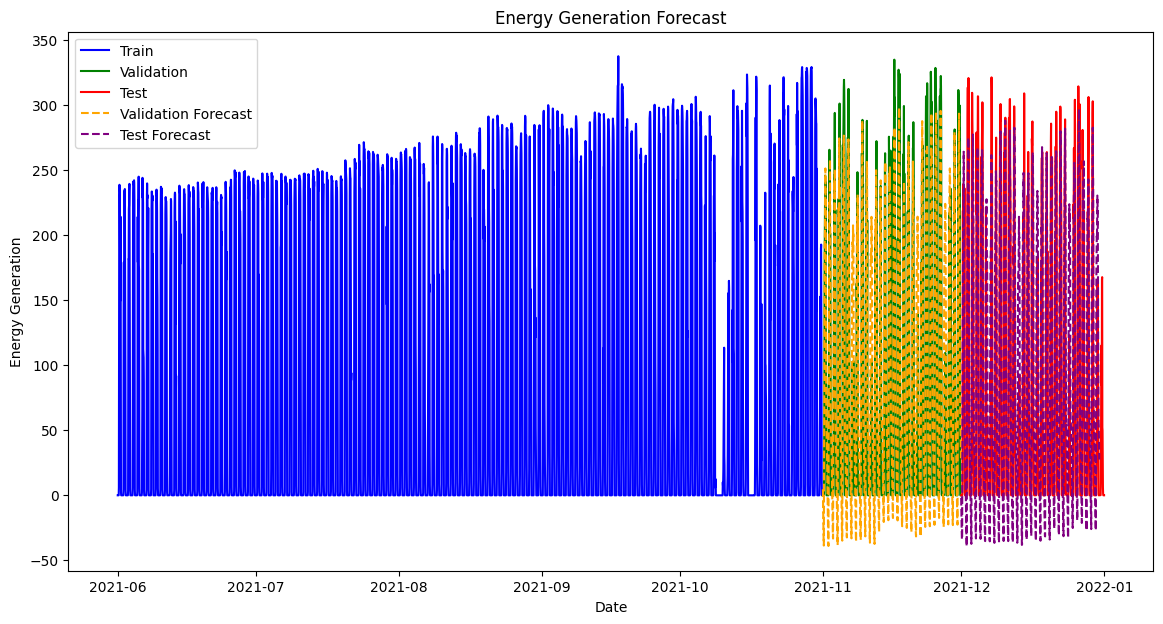

In [6]:
validation_mae = mean_absolute_error(endog_validation.head(steps), validation_forecast_mean)
validation_mse = mean_squared_error(endog_validation.head(steps), validation_forecast_mean)

test_mae = mean_absolute_error(endog_test.head(steps), test_forecast_mean)
test_mse = mean_squared_error(endog_test.head(steps), test_forecast_mean)

print(f"Validation MAE: {validation_mae:.2f}")
print(f"Validation MSE: {validation_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_mse:.2f}")
# Plot the results
plt.figure(figsize=(14, 7))

plt.plot(train.index, train['val_geracao'], label='Train', color='blue')
plt.plot(validation.index, validation['val_geracao'], label='Validation', color='green')
plt.plot(test.index, test['val_geracao'], label='Test', color='red')
plt.plot(validation.index[:steps], validation_forecast_mean, label='Validation Forecast', color='orange', linestyle='--')
plt.plot(test.index[:steps], test_forecast_mean, label='Test Forecast', color='purple', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.title('Energy Generation Forecast')
plt.legend()
plt.show()

In [7]:
train_prophet = train.reset_index().rename(columns={'timestamp': 'ds', 'val_geracao': 'y'})
validation_prophet = validation.reset_index().rename(columns={'timestamp': 'ds', 'val_geracao': 'y'})
test_prophet = test.reset_index().rename(columns={'timestamp': 'ds', 'val_geracao': 'y'})

# Start the timer
start_time = time.time()

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

# Create future dataframes for validation and test
future_validation = model.make_future_dataframe(periods=720, freq='H', include_history=False)
future_test = model.make_future_dataframe(periods=720, freq='H', include_history=False)

# Forecast for validation
validation_forecast = model.predict(future_validation)
validation_forecast_mean = validation_forecast['yhat']

# Forecast for test
test_forecast = model.predict(future_test)
test_forecast_mean = test_forecast['yhat']

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to create, fit, and forecast the model: {elapsed_time:.2f} seconds")



09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing


Time taken to create, fit, and forecast the model: 1.09 seconds


Validation MAE: 48.37
Validation MSE: 5106.87
Test MAE: 45.56
Test MSE: 4761.03


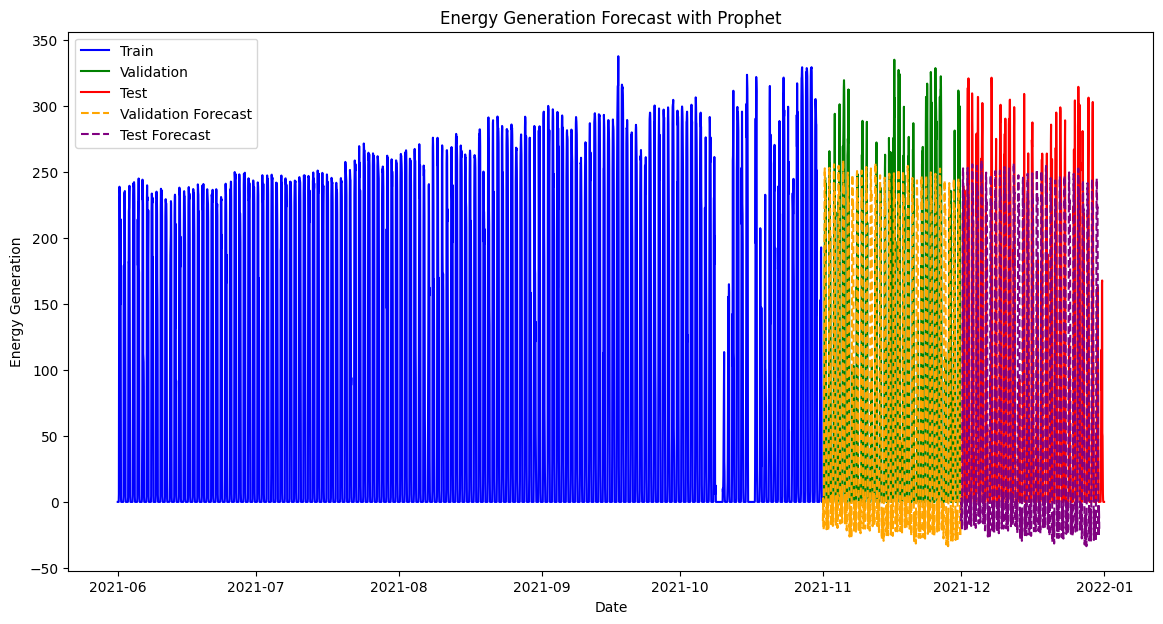

In [8]:
# Calculate error metrics for the validation forecast
validation_mae = mean_absolute_error(validation['val_geracao'][:720], validation_forecast_mean[:720])
validation_mse = mean_squared_error(validation['val_geracao'][:720], validation_forecast_mean[:720])

# Calculate error metrics for the test forecast
test_mae = mean_absolute_error(test['val_geracao'][:720], test_forecast_mean[:720])
test_mse = mean_squared_error(test['val_geracao'][:720], test_forecast_mean[:720])

print(f"Validation MAE: {validation_mae:.2f}")
print(f"Validation MSE: {validation_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_mse:.2f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['val_geracao'], label='Train', color='blue')
plt.plot(validation.index, validation['val_geracao'], label='Validation', color='green')
plt.plot(test.index, test['val_geracao'], label='Test', color='red')
plt.plot(validation.index[:720], validation_forecast_mean[:720], label='Validation Forecast', color='orange', linestyle='--')
plt.plot(test.index[:720], test_forecast_mean[:720], label='Test Forecast', color='purple', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.title('Energy Generation Forecast with Prophet')
plt.legend()
plt.show()